In [1]:
%matplotlib inline
import numpy, scipy, scipy.spatial, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

In [2]:
plt.style.use('seaborn-v0_8-muted')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

[&larr; Back to Index](index.html)

# Dynamic Time Warping Example

Load four audio files, all containing the same melody:

In [3]:
x1, sr1 = librosa.load('audio/sir_duke_trumpet_fast.mp3')
x2, sr2 = librosa.load('audio/sir_duke_trumpet_slow.mp3')
x3, sr3 = librosa.load('audio/sir_duke_piano_fast.mp3')
x4, sr4 = librosa.load('audio/sir_duke_piano_slow.mp3')

In [4]:
print(sr1, sr2, sr3, sr4)

22050 22050 22050 22050


Listen:

In [5]:
ipd.Audio(x1, rate=sr1)

In [6]:
ipd.Audio(x2, rate=sr2)

In [7]:
ipd.Audio(x3, rate=sr3)

In [8]:
ipd.Audio(x4, rate=sr4)

## Feature Extraction

Compute chromagrams:

In [9]:
hop_length = 256

In [10]:
C1_cens = librosa.feature.chroma_cens(y=x1, sr=sr1, hop_length=hop_length)
C2_cens = librosa.feature.chroma_cens(y=x2, sr=sr2, hop_length=hop_length)
C3_cens = librosa.feature.chroma_cens(y=x3, sr=sr3, hop_length=hop_length)
C4_cens = librosa.feature.chroma_cens(y=x4, sr=sr4, hop_length=hop_length)

In [11]:
print(C1_cens.shape)
print(C2_cens.shape)
print(C3_cens.shape)
print(C4_cens.shape)

(12, 455)
(12, 622)
(12, 669)
(12, 856)


Compute CQT only for visualization:

In [12]:
C1_cqt = librosa.cqt(y=x1, sr=sr1, hop_length=hop_length)
C2_cqt = librosa.cqt(y=x2, sr=sr2, hop_length=hop_length)
C3_cqt = librosa.cqt(y=x3, sr=sr3, hop_length=hop_length)
C4_cqt = librosa.cqt(y=x4, sr=sr4, hop_length=hop_length)

In [13]:
C1_cqt_mag = librosa.amplitude_to_db(abs(C1_cqt))
C2_cqt_mag = librosa.amplitude_to_db(abs(C2_cqt))
C3_cqt_mag = librosa.amplitude_to_db(abs(C3_cqt))
C4_cqt_mag = librosa.amplitude_to_db(abs(C4_cqt))

## DTW

Define DTW functions:

In [14]:
def dtw_table(x, y, distance=None):
    if distance is None:
        distance = scipy.spatial.distance.euclidean
    nx = len(x)
    ny = len(y)
    table = numpy.zeros((nx+1, ny+1))
    
    # Compute left column separately, i.e. j=0.
    table[1:, 0] = numpy.inf
        
    # Compute top row separately, i.e. i=0.
    table[0, 1:] = numpy.inf
        
    # Fill in the rest.
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            d = distance(x[i-1], y[j-1])
            table[i, j] = d + min(table[i-1, j], table[i, j-1], table[i-1, j-1])
    return table

In [15]:
def dtw(x, y, table):
    i = len(x)
    j = len(y)
    path = [(i, j)]
    while i > 0 or j > 0:
        minval = numpy.inf
        if table[i-1][j-1] < minval:
            minval = table[i-1, j-1]
            step = (i-1, j-1)
        if table[i-1, j] < minval:
            minval = table[i-1, j]
            step = (i-1, j)
        if table[i][j-1] < minval:
            minval = table[i, j-1]
            step = (i, j-1)
        path.insert(0, step)
        i, j = step
    return numpy.array(path)

Run DTW between pairs of signals:

In [16]:
D = dtw_table(C1_cens.T, C2_cens.T, distance=scipy.spatial.distance.cosine)

In [17]:
path = dtw(C1_cens.T, C2_cens.T, D)

## Evaluate

Listen to the both recordings at the same alignment marker:

In [18]:
path.shape

(630, 2)

In [19]:
i1, i2 = librosa.frames_to_samples(path[113], hop_length=hop_length)
print(i1, i2)

21248 28160


In [20]:
ipd.Audio(x1[i1:], rate=sr1)

In [21]:
ipd.Audio(x2[i2:], rate=sr2)

Visualize both signals and their alignment:

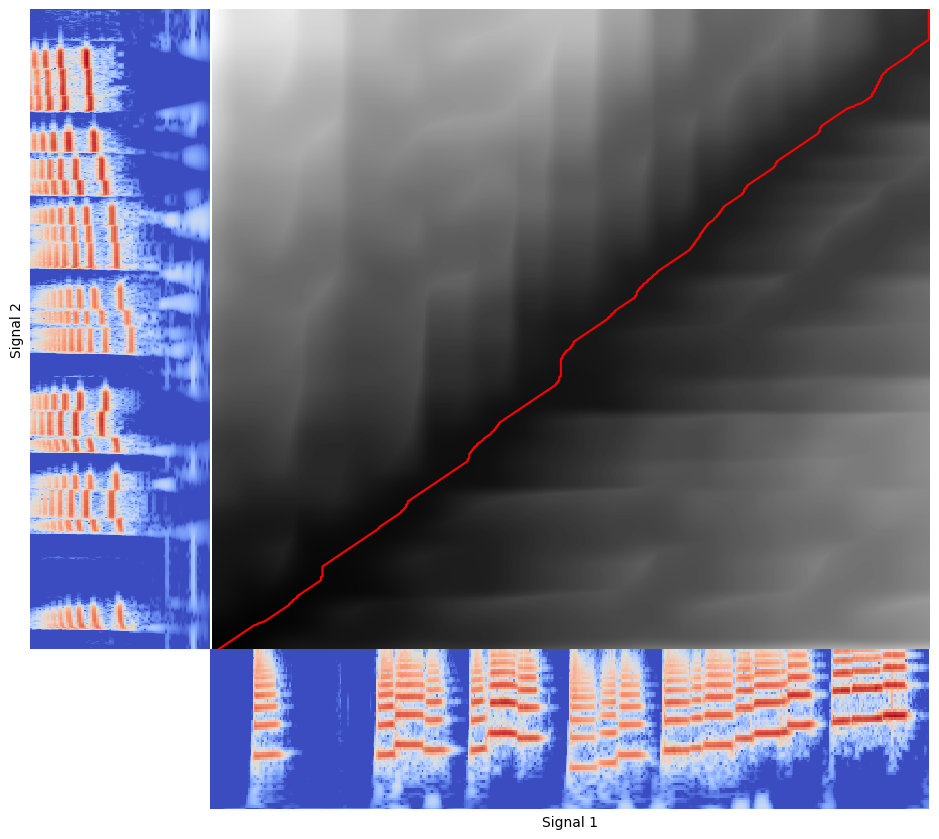

In [22]:
plt.figure(figsize=(9, 8))

# Bottom right plot.
ax1 = plt.axes([0.2, 0, 0.8, 0.20])
ax1.imshow(C1_cqt_mag, origin='lower', aspect='auto', cmap='coolwarm')
ax1.set_xlabel('Signal 1')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(20)

# Top left plot.
ax2 = plt.axes([0, 0.2, 0.20, 0.8])
ax2.imshow(C2_cqt_mag.T[:,::-1], origin='lower', aspect='auto', cmap='coolwarm')
ax2.set_ylabel('Signal 2')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(20)

# Top right plot.
ax3 = plt.axes([0.2, 0.2, 0.8, 0.8], sharex=ax1, sharey=ax2)
ax3.imshow(D.T, aspect='auto', origin='lower', interpolation='nearest', cmap='gray')
ax3.set_xticks([])
ax3.set_yticks([])

# Path.
ax3.plot(path[:,0], path[:,1], 'r');

[]

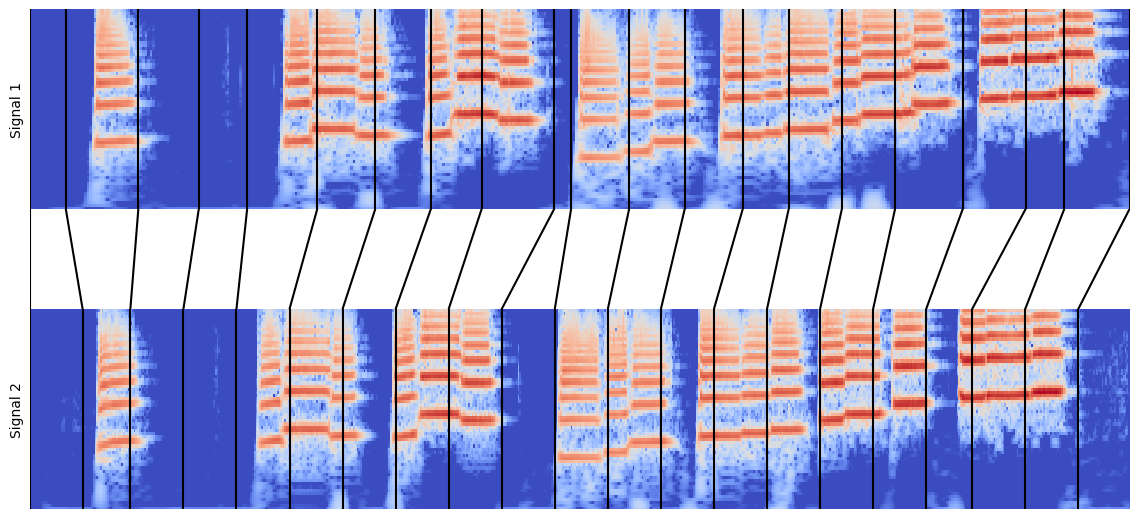

In [23]:
plt.figure(figsize=(11, 5))

# Top plot.
ax1 = plt.axes([0, 0.60, 1, 0.40])
ax1.imshow(C1_cqt_mag, origin='lower', aspect='auto', cmap='coolwarm')
ax1.set_ylabel('Signal 1')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(20)
ax1.set_xlim(0, C1_cqt.shape[1])

# Bottom plot.
ax2 = plt.axes([0, 0, 1, 0.40])
ax2.imshow(C2_cqt_mag, origin='lower', aspect='auto', cmap='coolwarm')
ax2.set_ylabel('Signal 2')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(20)
ax2.set_xlim(0, C2_cqt.shape[1])

# Middle plot.
line_color = 'k'
step = 30
n1 = float(C1_cqt.shape[1])
n2 = float(C2_cqt.shape[1])
ax3 = plt.axes([0, 0.40, 1, 0.20])
for t in path[::step]:
    ax3.plot((t[0]/n1, t[1]/n2), (1, -1), color=line_color)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(-1, 1)

# Path markers on top and bottom plot.
y1_min, y1_max = ax1.get_ylim()
y2_min, y2_max = ax2.get_ylim()
ax1.vlines([t[0] for t in path[::step]], y1_min, y1_max, color=line_color)
ax2.vlines([t[1] for t in path[::step]], y2_min, y2_max, color=line_color)
ax3.set_xticks([])
ax3.set_yticks([])

## Exercises

Try each pair of audio files among the following:

In [24]:
ls audio/sir_duke*

audio/sir_duke_piano_fast.mp3    audio/sir_duke_trumpet_fast.mp3
audio/sir_duke_piano_slow.mp3    audio/sir_duke_trumpet_slow.mp3


Try adjusting the hop length, distance metric, and feature space.

Instead of `chroma_cens`, try `chroma_stft` or `librosa.feature.mfcc`.

Try magnitude scaling the feature matrices, e.g. `amplitude_to_db` or $\log(1 + \lambda x)$.

[&larr; Back to Index](index.html)